In [6]:
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import emcee
from scipy import stats
import corner

import ModelDefinitions as MD
import LogProb as LP
import importlib
from const import *
importlib.reload(LP)
importlib.reload(MD)

<module 'ModelDefinitions' from '/home/nitikayad96/Research/Radio_Background/radio-background/ModelDefinitions.py'>

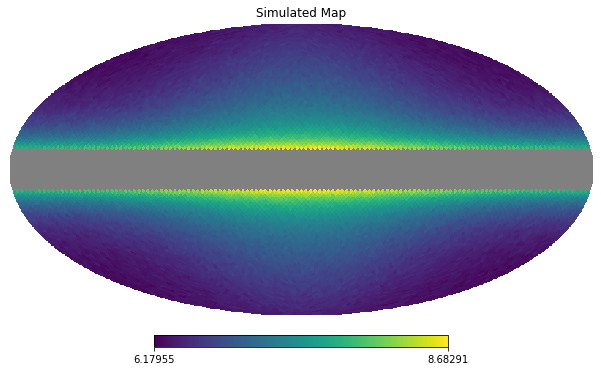

In [7]:
nu=1.4e9
param_init = [1.5*d, 0.2*d, 10**(-40), 3.0*d, 10**(-41), 2.0]
R_diski, h_diski, j_diski, R_haloi, j_haloi, T_bkgi = param_init
sim = MD.sim_map(T_bkgi, R_diski, h_diski, j_diski, R_haloi, j_haloi, nu, noise = 0.03) + T_CMB + T_eg
sim[idx_exb] = None
hp.mollview(sim, title="Simulated Map")
#plt.savefig('notes/simulated_map.jpg')

In [ ]:
def lnprior(param):
    
    R_disk = param[0]
    h_disk = param[1]
    j_disk = param[2]
    R_halo = param[3]
    j_halo = param[4]
    T_bkg = param[5]
    
    if d < R_disk < 20*d and 0 < h_disk < 5*d and 1e-42 < j_disk < 1e-39 and d < R_halo < 20*d and 1e-42 < j_halo < 1e-39 and 0 <= T_bkg <= 10:
        return 0.0

    else:
        return -np.inf


### full log probability ###

def lnprob(param, nu, l, b, T_sky):
    lp = lnprior(param)
    if not np.isfinite(lp):
        return -np.inf
    return lp + LP.diskhalobkg(param, nu, l, b, T_sky)


### initialize walkers ###
ndim = len(param_init)
nwalkers = 200

param_start = param_init*np.abs(np.random.randn(ndim) + 1.)
init = [param_start]
for i in range(nwalkers-1):
    #start walkers such that all values are positive, std is 0.1, and mean multiplicative factor is 1
    vary = np.abs(np.random.randn(ndim) + 1.)
    init.append([param_start[i]*vary[i] for i in range(ndim)])
    
init = np.array(init)

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(nu, l, b, sim), threads=8)

SAMPLER = sampler.run_mcmc(init, 1000, progress=True)

In [ ]:
samples = np.array(sampler.chain)
print(np.mean(sampler.acceptance_fraction))
ndim = len(param_init)
samples = samples[:,200:,:]
samples_reshape = samples.reshape((-1, ndim))


samples_reshape[:,0] = np.log10(samples_reshape[:,0])
samples_reshape[:,1] = np.log10(samples_reshape[:,1])
samples_reshape[:,2] = np.log10(samples_reshape[:,2])
samples_reshape[:,3] = np.log10(samples_reshape[:,3])
samples_reshape[:,4] = np.log10(samples_reshape[:,4])
#samples_reshape[:,5] = np.log10(samples_reshape[:,5])



In [ ]:
plt.figure()
for i in range(20):
    plt.plot(samples[i,:,5])
    plt.yscale('log')

In [ ]:
fig = corner.corner(samples_reshape, labels=["log($R_{disk})$", "$log(h_{disk})$", "$log(j_{disk})$", "$log(R_{halo})$", "$log(j_{halo})$", "$T_{bkg}$"],
                    label_kwargs={"fontsize": 12}, show_titles=True, title_kwargs={"fontsize": 12},
                    quantiles=[0.16,0.5,0.84])

plt.savefig('notes/corner_simdata.jpg')

In [ ]:
print(np.log10(param_init))

In [ ]:
R_disk = 10**np.percentile(samples_reshape[:,0], 50)
h_disk = 10**np.percentile(samples_reshape[:,1], 50)
j_disk = 10**np.percentile(samples_reshape[:,2], 50)
R_halo = 10**np.percentile(samples_reshape[:,3], 50)
j_halo = 10**np.percentile(samples_reshape[:,4], 50)
T_bkg = np.percentile(samples_reshape[:,5], 50)

residuals = sim - (MD.LineOfSightDisk(l, b, d, R_disk, h_disk)*j_disk + MD.LineOfSightHalo(l, b, d, R_halo)*j_halo)*(c**2)/(2*k*(nu**2)) - T_CMB - T_eg - T_bkg

In [ ]:
hp.mollview(residuals)
plt.figure()
plt.hist(residuals)

